In [1]:
DATASETS_PATH ="/datasets/"

In [27]:
import os
import tarfile
import urllib
import sklearn.model_selection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zlib import crc32
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [2]:
#DOWNLOAD_ROOT
TITANIC_PATH = os.path.join("datasets","titanic")
def load_titanic_data(titanic_path = TITANIC_PATH):
    csv_path = os.path.join(titanic_path, "train.csv")
    return pd.read_csv(csv_path)
def load_titanic_test(titanic_path = TITANIC_PATH):
    csv_path = os.path.join(titanic_path, "test.csv")
    return pd.read_csv(csv_path)

titanic_data = load_titanic_data()
titanic_labels = titanic_data["Survived"].copy()
titanic_data = titanic_data.drop('Ticket',axis = 1)
titanic_data = titanic_data.drop('Name',axis = 1)
titanic_data = titanic_data.drop('Survived',axis = 1)
titanic_data = titanic_data.drop('Cabin',axis = 1)
titanic_numerical = titanic_data.drop([ "Sex", "Embarked"],axis = 1)
titanic_data.head()
titanic_test = load_titanic_test()
titanic_test = titanic_test.drop('Ticket',axis = 1)
titanic_test = titanic_test.drop('Name',axis = 1)
titanic_test = titanic_test.drop('Cabin',axis = 1)

In [3]:
imputer = SimpleImputer(strategy= "median")
cat_attribs = [ "Sex", "Embarked"]
titanic_categorical = titanic_data[cat_attribs]
cat_encoder = OneHotEncoder()
titanic_categorical_1hot = cat_encoder.fit_transform(titanic_categorical)
titanic_categorical_1hot.shape

(891, 6)

In [4]:
num_attribs = list(titanic_numerical)
cat_attribs = [ "Sex", "Embarked"]
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    object 
 3   Age          714 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [5]:
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy = "median")),
    ("std_scaler", StandardScaler()),
])
full_pipeline = ColumnTransformer([
    ("num", numerical_pipeline, num_attribs),
    ("cat",OneHotEncoder(sparse = False), cat_attribs),
])


In [6]:

titanic_prepared_data = full_pipeline.fit_transform(titanic_data.copy())
titanic_prepared_data.shape


(891, 12)

0.7696982285708198

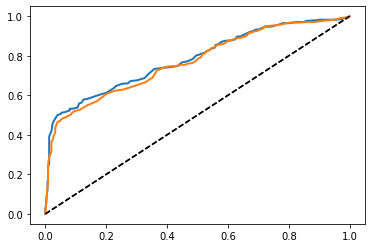

In [19]:
forest_clf = RandomForestClassifier()
forest_clf.fit(titanic_prepared_data, titanic_labels)
scores =cross_val_predict(forest_clf, titanic_prepared_data, titanic_labels, cv = 2, method = "predict_proba")
svc = SVC(gamma ='auto')
svc_scores =cross_val_predict(forest_clf, titanic_prepared_data, titanic_labels, cv = 2, method = "predict_proba")
svc_y_scores = svc_scores[:,1]
fpr_svc, tpr_svc, thresholds_svc =  roc_curve(titanic_labels, svc_y_scores)
y_scores_forest = scores[:,1]
fpr_forest, tpr_forest, thresholds_forest =  roc_curve(titanic_labels, y_scores_forest)
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr, linewidth = 2, label = None)
    plt.plot([0,1],[0,1], 'k--')
plot_roc_curve(fpr_forest,tpr_forest)
roc_auc_score(titanic_labels, y_scores_forest)
plot_roc_curve(fpr_svc,tpr_svc)
roc_auc_score(titanic_labels, svc_y_scores)

In [ ]:
s

In [23]:
param_grid =[
    {'n_neighbors': [3,5,8, 12], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'kd_tree']}
]
param_grid_SVC = [
    {'kernel': ['linear', 'poly', 'rbf'],'gamma' : ['scale', 'auto']}
]
grid_svc = SVC()
grid_search_svc = GridSearchCV(grid_svc, param_grid_SVC, cv = 2, scoring = "f1", return_train_score= True)
grid_search_svc.fit(titanic_prepared_data,titanic_labels)
final_model_svc= grid_search.best_estimator_

In [21]:
param_grid_forest = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
grid_forest = RandomForestClassifier()
grid_search = GridSearchCV(grid_forest, param_grid_forest, cv = 2, scoring = "f1", return_train_score= True)
grid_search.fit(titanic_prepared_data,titanic_labels)
final_model_forest= grid_search.best_estimator_

In [24]:
titanic_prepared_test = full_pipeline.transform(titanic_test.copy())
svc_preds = final_model_svc.predict(titanic_prepared_test)
print(svc_preds)
forest_preds = final_model_forest.predict(titanic_prepared_test)
print(forest_preds)


[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 0]
[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 

In [25]:
titanic_test = load_titanic_test()
ids = titanic_test["PassengerId"]
survived_preds =  pd.DataFrame({'Survived': forest_preds}, index = ids.index)
w = pd.concat([ids,survived_preds], axis = 1)
w.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [26]:
pd.DataFrame((np.array(w))).to_csv("trial.csv", index = False)